In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import gym
import argparse
import numpy as np
from ns3gym import ns3env
from DQN_model import DeepQNetwork
from DQN_model import Eval_Model
from DQN_model import Target_Model
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
learning_rate = 0.01
reward_decay = 0.9
e_greedy = 0.9
replace_target_iter = 100
memory_size = 500
batch_size = 32
training_episodes = 50
max_choice = 3
optimized_choice = []
throughput_list = []
throughput_history = []
delay_list = []
delay_history = []

max_throughput = 25*576*20
episode_time = 600
eval_model_weights_path = ''#'/workspace/model/eval_model_weights'
target_model_weights_path = ''#'/workspace/model/target_model_weights'


In [3]:
#env = gym.make('ns3-v0')
env = ns3env.Ns3Env(debug=True)

#env.reset()

ob_space = env.observation_space
ac_space = env.action_space
ob_space_n = ob_space['slotUsedTable'].shape[0] + ob_space['pktBytes'].shape[0] - 1
n_slotUsedTable = ob_space['slotUsedTable'].shape[0]


print("Observation space: ", ob_space,  ob_space.dtype)
print("Action space: ", ac_space, ac_space.dtype)
print("n_action: ",ac_space.shape[0])

Got new port for ns3gm interface:  5021
Start command:  /tf/ns3-gym/waf --run "tdma-rl --openGymPort=5021 --simSeed=2965727002"
Started ns3 simulation script, Process Id:  21772
Observation space:  Dict(pktBytes:Box(4,), slotUsedTable:Box(32,)) None
Action space:  Box(32,) int64
n_action:  32


In [4]:
eval_model = Eval_Model(num_actions=ac_space.shape[0])
target_model = Target_Model(num_actions=ac_space.shape[0])
try:
    eval_model.load_weights(eval_model_weights_path)
    target_model.load_weights(target_model_weights_path)
    print('Load weights from ',eval_model_weights_path," and ",target_model_weights_path)
except:
    print('Create new model')

    
RL = DeepQNetwork(ac_space.shape[0], max_choice, ob_space_n,
                  eval_model, target_model, learning_rate, reward_decay, e_greedy, 
                  replace_target_iter, memory_size, batch_size)

Create new model


In [5]:
def slot_scoring(obs):
    values = np.random.random_sample((32,)) / 20
    
    #values = np.zeros((32,)) 
    #values[np.nonzero(obs[:n_slotUsedTable])] = -np.inf
    
    top_index = []
    for i in range(3):
        top_index.append(np.ravel(np.argwhere(obs[:n_slotUsedTable]==i+1)))
    
    for act in range(32):
        r = 0
        max_r = 0
        for i in range(3):
            if any(act < idx for idx in top_index[i]):
                distance_map = top_index[i] - act
                distance = min(np.where(distance_map>0,distance_map,np.inf))
                closest_distance = 0
                for idx in range(int(distance)):
                    closest_distance = closest_distance + 1 if obs[act+idx] == 0 else closest_distance
                    
                distance_reward = (1.8-pow((closest_distance/10),0.5))
                #distance_reward = (pow((closest_distance/10),0.1)-0.7)
                size_weight = pow(_obs[-(3-i)],0.3)
                max_r =  max((distance_reward*size_weight/3),max_r)
                #r += (0.3*size_weight)

            
        #if all(idx.size == 0 for idx in top_index):
        #    closest_distance = n_slotUsedTable - act
        #    #distance_reward = (1.2-pow((closest_distance/10),0.1))
        #    distance_reward = (pow((closest_distance/10),0.1)-0.7)
        #    r += distance_reward
                
        values[act] = r + max_r
    
    values[np.nonzero(obs[:n_slotUsedTable])] = -np.inf
    
    #print ("obs:",obs[:n_slotUsedTable])
    #print ("values:",values)
    
    return values

In [6]:
def slot_select(q_values, choosable_slotNum, slot_table):
    # get top N value of q value
    q_values[np.nonzero(slot_table)] = -np.inf
    action_unsort = np.argpartition(q_values,-max_choice)[-max_choice:]
    
    # sort action num by q value
    action = action_unsort[np.argsort(-1*q_values[action_unsort])]
    
    
    max_choosable_slotNum = min(choosable_slotNum, max_choice)
    # Using the queuing bytes to decide how many data slot would be choose
    action_num = 0 if queueBytes == 0 else min(max(0, int(queueBytes/6250 - 0.3)) + 1, max_choosable_slotNum)
        
    action[action_num:] = [-1] * (max_choice-action_num)
    
    # sort action num
    action[:action_num] = np.sort(action[:action_num])
    
    return action

In [7]:
for episode in range(training_episodes):

    isTraining = True if (episode+1)%10 != 0 else False
    if isTraining:
        print ("-----------------------episodes: ", episode, " (Training)----------------------")
    else:
        print ("-----------------------episodes: ", episode, " (Testing)-----------------------")

    stepIdx = 0
    total_choice_counter = 0
    optimized_choice_counter = 0
    nonLearn_data = 0
    throughput = 0
    delay = 0
    
    _obs = env.reset()
    queueBytes = _obs[1][0]
    
    choosable_slotNum = min(n_slotUsedTable - np.nonzero(_obs[0])[0].size,max_choice)
    
    _obs = np.array(list(_obs[0]) + list(_obs[1][1:]))
    _obs = np.pad(_obs,(0, ob_space_n - _obs.size), constant_values = 0)
    
    
    while True:
        stepIdx += 1

        action = np.array(slot_select(RL.choose_action(_obs, isTraining),choosable_slotNum,_obs[:n_slotUsedTable]))
        
        #action = np.array(slot_select(slot_scoring(_obs),choosable_slotNum,_obs[:n_slotUsedTable]))
        
        #print("---action: ", action)
        obs, reward, done, info = env.step(action)

        
        if info == "TimeOut":
            print("Step: ", stepIdx)
            
            print ("Throughput :", throughput)
            print ("delay :", delay," μs")

            if total_choice_counter != 0:
                optimized_choice.append(optimized_choice_counter/total_choice_counter)
            
            throughput_list.append(throughput)
            delay_list.append(delay)
            
            break
        
        choosable_slotNum = min(n_slotUsedTable - np.nonzero(obs[0])[0].size,max_choice)
        
        # Get queuing bytes
        queueBytes = obs[1][0]
        
        # Since there are multiple action in one step,
        # according to each action, it would have one reward.
        # But in ns3gym, the reward type is float, it means it can only return one reward,
        # we use the return info to send multiple reward
        
        reward_all = [float(r) for r in info.split(',')]
        throughput = reward_all[-2]
        delay = reward_all[-1]
        reward_all = reward_all[:-2]
        
        if throughput != 0:
            throughput_history.append(throughput)
        
        if delay != 0:
            delay_history.append(delay)
            
        #reward_all = [0,0,0]
        info = stepIdx
        
        #print("Step: ", stepIdx)
        #print("---obs, reward, done, info: ", obs, reward_all, done, info)
        
        obs = np.array(list(obs[0]) + list(obs[1][1:]),dtype=float)
        obs = np.pad(obs,(0, ob_space_n - obs.size), constant_values = 0)
        obs[n_slotUsedTable:] = obs[n_slotUsedTable:]/queueBytes if queueBytes != 0 else np.zeros(3)
        
        top_index = []
        for i in range(3):
            top_index.append(np.ravel(np.argwhere(_obs[:n_slotUsedTable]==i+1)))
        
        for act, r in zip(action,reward_all):
            if act == -1:
                continue
            
            
            total_choice_counter += 1
            nonLearn_data += 1
            
            if (act not in np.nonzero(_obs[:n_slotUsedTable])[0]):
                r += 0.2
                
                #print ("act:",act)
                #print ("r:",r)
                #print ("throughput:",throughput)
                
                isChosen = False
                max_r = 0
                # Add optimized reward
                for i in range(3):
                    if any(act < idx for idx in top_index[i]):
                        distance_map = top_index[i] - act
                        distance = min(np.where(distance_map>0,distance_map,np.inf))
                        closest_distance = 0
                        for idx in range(closest_distance):
                            closest_distance = closest_distance + 1 if obs[act+idx] == 0 else closest_distance
                    
                        distance_reward = (1.8-pow((closest_distance/10),0.5))
                        #distance_reward = (pow((closest_distance/10),0.1)-0.7)
                        size_weight = pow(_obs[-(3-i)],0.3)
                        max_r =  max((distance_reward*size_weight/3),max_r) + throughput/max_throughput/2
                        #r += (0.3*size_weight) + throughput/max_throughput/2
                        
                        if not isChosen:
                            isChosen = True
                            optimized_choice_counter += 1
                            
                """
                if all(idx.size == 0 for idx in top_index):
                    closest_distance = n_slotUsedTable - act
                    #distance_reward = (1.2-pow((closest_distance/10),0.1))
                    distance_reward = (pow((closest_distance/10),0.1)-0.7)
                    r += distance_reward + throughput/max_throughput/2
                    #r += throughput/max_throughput/2
                """
                
                
                
            if isTraining:
                r += max_r
                RL.store_transition(_obs, act, r, obs)
            

                
        #if stepIdx % 10000 == 0:
        #    print("Step: ", stepIdx)
        
        if (total_choice_counter > 1000) and (nonLearn_data > 10) and isTraining:
            nonLearn_data = 0
            RL.learn()
            
        # swap observation
        _obs = obs
        
        
        if done:
            print("Step: ", stepIdx)
            print ("done")
            
            print ("Throughput :", throughput)
            print ("delay :", delay," μs")
            
            if total_choice_counter != 0:
                optimized_choice.append(optimized_choice_counter/total_choice_counter)
            
            throughput_list.append(throughput)
            delay_list.append(delay)
            
            break
            
        #break

-----------------------episodes:  0  (Training)----------------------
Step:  120000
done
Throughput : 229510.0
delay : 131406.0  μs
-----------------------episodes:  1  (Training)----------------------
Got new port for ns3gm interface:  6898
Start command:  /tf/ns3-gym/waf --run "tdma-rl --openGymPort=6898 --simSeed=4110393919"
Started ns3 simulation script, Process Id:  6270
Step:  120000
done
Throughput : 229491.0
delay : 131535.0  μs
-----------------------episodes:  2  (Training)----------------------
Got new port for ns3gm interface:  8019
Start command:  /tf/ns3-gym/waf --run "tdma-rl --openGymPort=8019 --simSeed=2055084319"
Started ns3 simulation script, Process Id:  23326
Step:  120000
done
Throughput : 229334.0
delay : 131496.0  μs
-----------------------episodes:  3  (Training)----------------------
Got new port for ns3gm interface:  5330
Start command:  /tf/ns3-gym/waf --run "tdma-rl --openGymPort=5330 --simSeed=268606813"
Started ns3 simulation script, Process Id:  7972
Ste

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-64e750df1ef3>", line 28, in <module>
    action = np.array(slot_select(RL.choose_action(_obs, isTraining),choosable_slotNum,_obs[:n_slotUsedTable]))
  File "/tf/ns3-gym/scratch/tdma-rl/DQN_model.py", line 219, in choose_action
    actions_value = self.eval_model.predict(observation)[0]
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 87, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 1181, in predict
    model=self)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/data_adapter.py", line 1124, in __init__
    model=model)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ke

KeyboardInterrupt: 

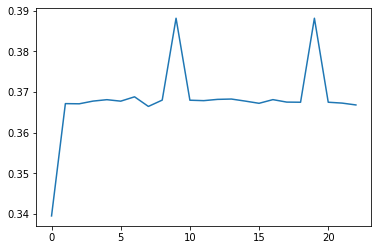

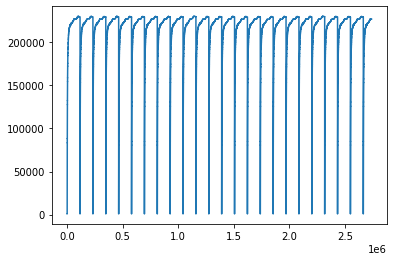

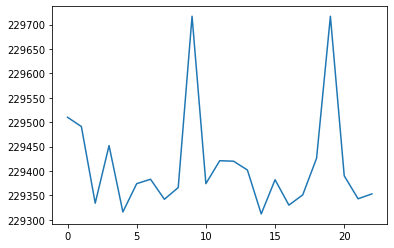

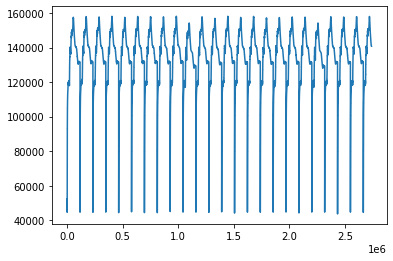

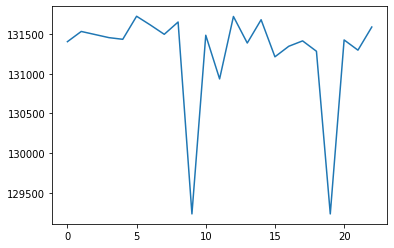

In [8]:
# step counter of each episode
plt.plot(optimized_choice)
plt.show()

plt.plot(throughput_history)
plt.show()

plt.plot(throughput_list)
plt.show()

plt.plot(delay_history)
plt.show()

plt.plot(delay_list)
plt.show()

In [ ]:
RL.plot_cost()

In [ ]:
env.close()

In [ ]:
eval_model.save_weights('/workspace/model/eval_model_weights')
target_model.save_weights('/workspace/model/target_model_weights')